# Briefing

* This notebook analyses whether there is a correlation between the daily number of taxi rides in NYC and the daily weather (especially the precipitation) between January 2009 and December 2017.

# Setup: Imports, Configuration and Data Loading

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

%matplotlib inline
color = sns.color_palette()

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%config InlineBackend.figure_format = 'retina'

In [10]:
rides = pd.read_csv('~/repos/nyc-taxi/reports/num_rides_by_day.csv', index_col='pickup_date_as_day')
rides.index.name = 'date'
rides.shape
rides.head()

(3287, 1)

,num_rides
date,
2009-01-01,327716
2009-01-02,376708
2009-01-03,432710
2009-01-04,367525
2009-01-05,370901


* Based on the exploratory data analysis, six weather variables have been selected for further correlation analysis with the number of rides per day.

In [11]:
selected_weather_variables = ['DATE',
                              'PRCP',  # precipitation
                              'SNOW',  # snowfall
                              'SNWD',  # snow depth
                              'TMAX',  # maximum temperature
                              'TMIN',  # minimum temperature
                              'AWND'   # average wind speed
                             ]

weather = pd.read_csv('~/repos/nyc-taxi/resources/weather/NOAA_Central_Park_data.csv', 
                      index_col='DATE', 
                      usecols=selected_weather_variables)
weather.index.name = 'date'
weather.shape
weather.head()

(3287, 6)

,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
date,,,,,,
2009-01-01,5.0,0.0,0.0,0.0,-3.3,-9.4
2009-01-02,2.8,0.0,0.0,0.0,1.1,-5.0
2009-01-03,4.5,0.0,0.0,0.0,3.3,-1.7
2009-01-04,3.4,0.0,0.0,0.0,5.6,-3.9
2009-01-05,3.1,0.0,0.0,0.0,6.1,3.3


In [12]:
data = rides.join(weather, how='left')
data.index = pd.to_datetime(data.index)
data.shape
data.head()

(3287, 7)

,num_rides,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
date,,,,,,,
2009-01-01,327716,5.0,0.0,0.0,0.0,-3.3,-9.4
2009-01-02,376708,2.8,0.0,0.0,0.0,1.1,-5.0
2009-01-03,432710,4.5,0.0,0.0,0.0,3.3,-1.7
2009-01-04,367525,3.4,0.0,0.0,0.0,5.6,-3.9
2009-01-05,370901,3.1,0.0,0.0,0.0,6.1,3.3


# First Glance At the Data

* First, get a feeling for the ranges, min, max, median values.

In [13]:
data.describe()

,num_rides,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
count,3.287000e+03,3252.000000,3287.000000,3287.000000,3287.000000,3287.000000,3287.000000
mean,5.714173e+05,2.499139,3.422026,2.679039,14.155461,17.369151,9.457530
std,1.622191e+05,1.103753,9.764259,22.806340,60.408680,10.176563,9.278581
min,2.902800e+04,0.100000,0.000000,0.000000,0.000000,-9.300000,-18.200000
25%,4.692620e+05,1.700000,0.000000,0.000000,0.000000,9.400000,2.200000
50%,5.207710e+05,2.300000,0.000000,0.000000,0.000000,18.300000,10.000000
75%,6.540240e+05,3.100000,1.300000,0.000000,0.000000,26.100000,17.800000
max,1.218750e+06,10.200000,147.600000,693.000000,584.000000,40.000000,28.900000


* The most obvious thing to check is the correlation between the columns.

In [14]:
data.corr()

,num_rides,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
num_rides,1.000000,-0.065174,-0.043796,-0.099310,-0.088527,-0.011140,-0.015241
AWND,-0.065174,1.000000,0.161877,0.173963,0.133802,-0.504006,-0.490858
PRCP,-0.043796,0.161877,1.000000,0.228377,0.003935,-0.015905,0.035375
SNOW,-0.099310,0.173963,0.228377,1.000000,0.222153,-0.189744,-0.179518
SNWD,-0.088527,0.133802,0.003935,0.222153,1.000000,-0.340507,-0.346324
TMAX,-0.011140,-0.504006,-0.015905,-0.189744,-0.340507,1.000000,0.959848
TMIN,-0.015241,-0.490858,0.035375,-0.179518,-0.346324,0.959848,1.000000


* On the first glance, it doesn't seem that there is a clear correlation between number of rides and weather.
* Now, let's take a look at the timely patterns.

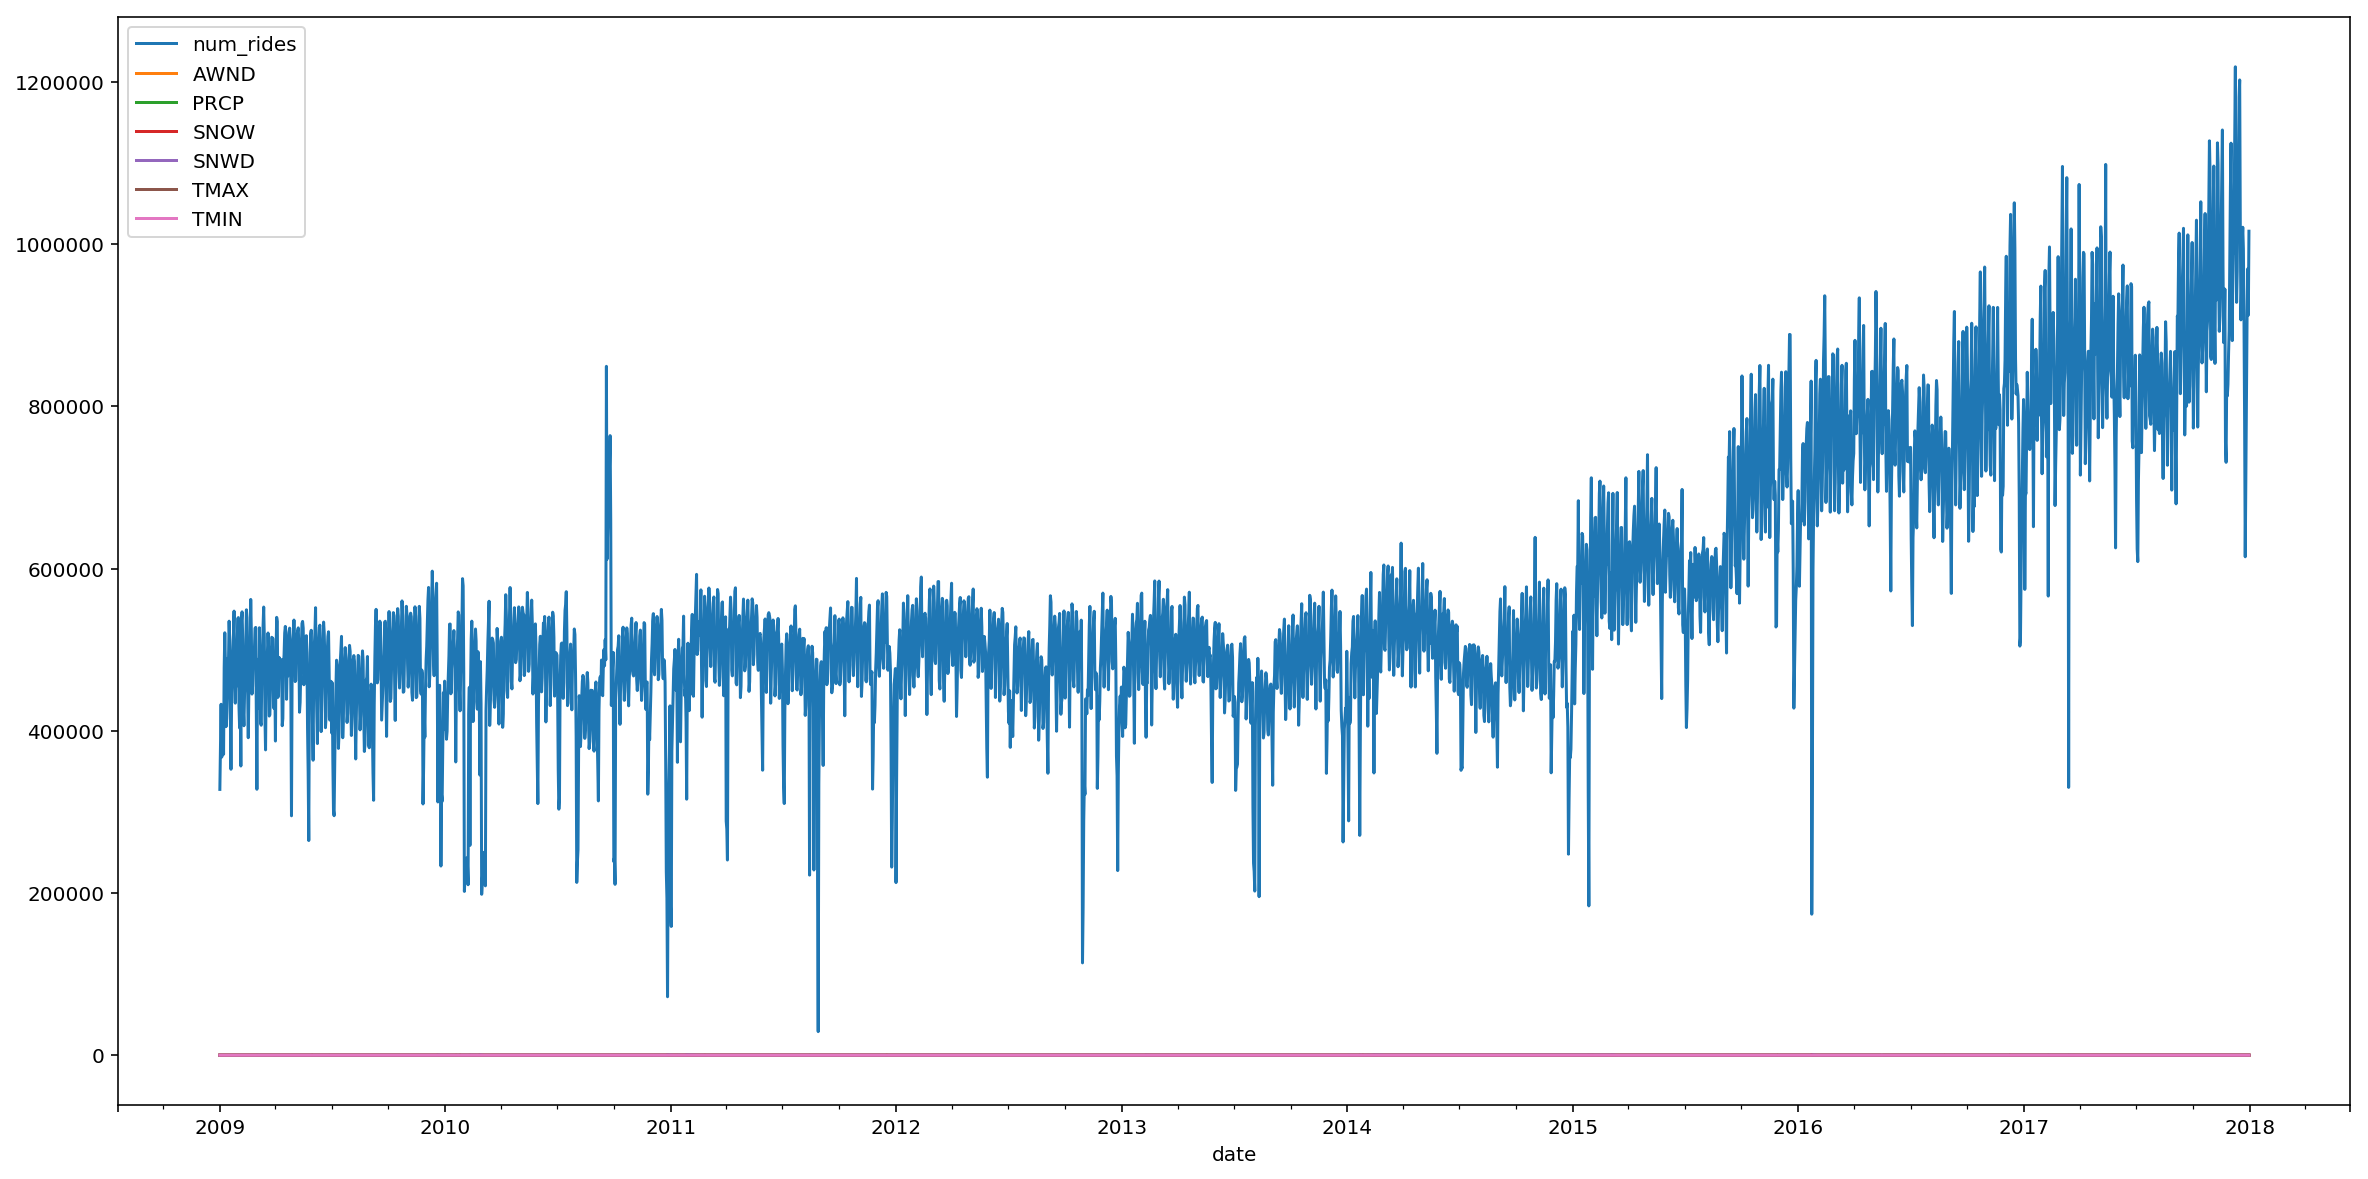

In [15]:
data.plot(figsize=(20, 10))

Observations:
* Since data is not normalised, the scales do not match (needs to be normalised to compare in same plot).
* From 2015/2016 there were many more rides in the dataset than before. This is due to the FHV rides kicking in from 2015. Not only is this data available from 2015, the number of FHV rides also increases significantly until December 2017.
* It looks like there's a seasonal pattern within a year.
* There are some spike, very few with many more rides than usual (around 2010) and quite a few with many less rides than usual (e.g. 2011, 2016).

Next steps:
* Normalise time series to make them comparable and more easily identify patterns
* Better understand yearly patterns
* Understand patterns for spikes

# Normalisation

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [17]:
data_minmax = data.copy(deep=True)
data_std = data.copy(deep=True)

for col in list(data):
    minmax_scaler = MinMaxScaler()
    data_minmax[col] = minmax_scaler.fit_transform(data_minmax[col].values.reshape(-1, 1))
    
    std_scaler = StandardScaler()
    data_std[col] = std_scaler.fit_transform(data_std[col].values.reshape(-1, 1))

/opt/miniconda/envs/nyc-taxi/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/miniconda/envs/nyc-taxi/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/miniconda/envs/nyc-taxi/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## MinMax Scaling

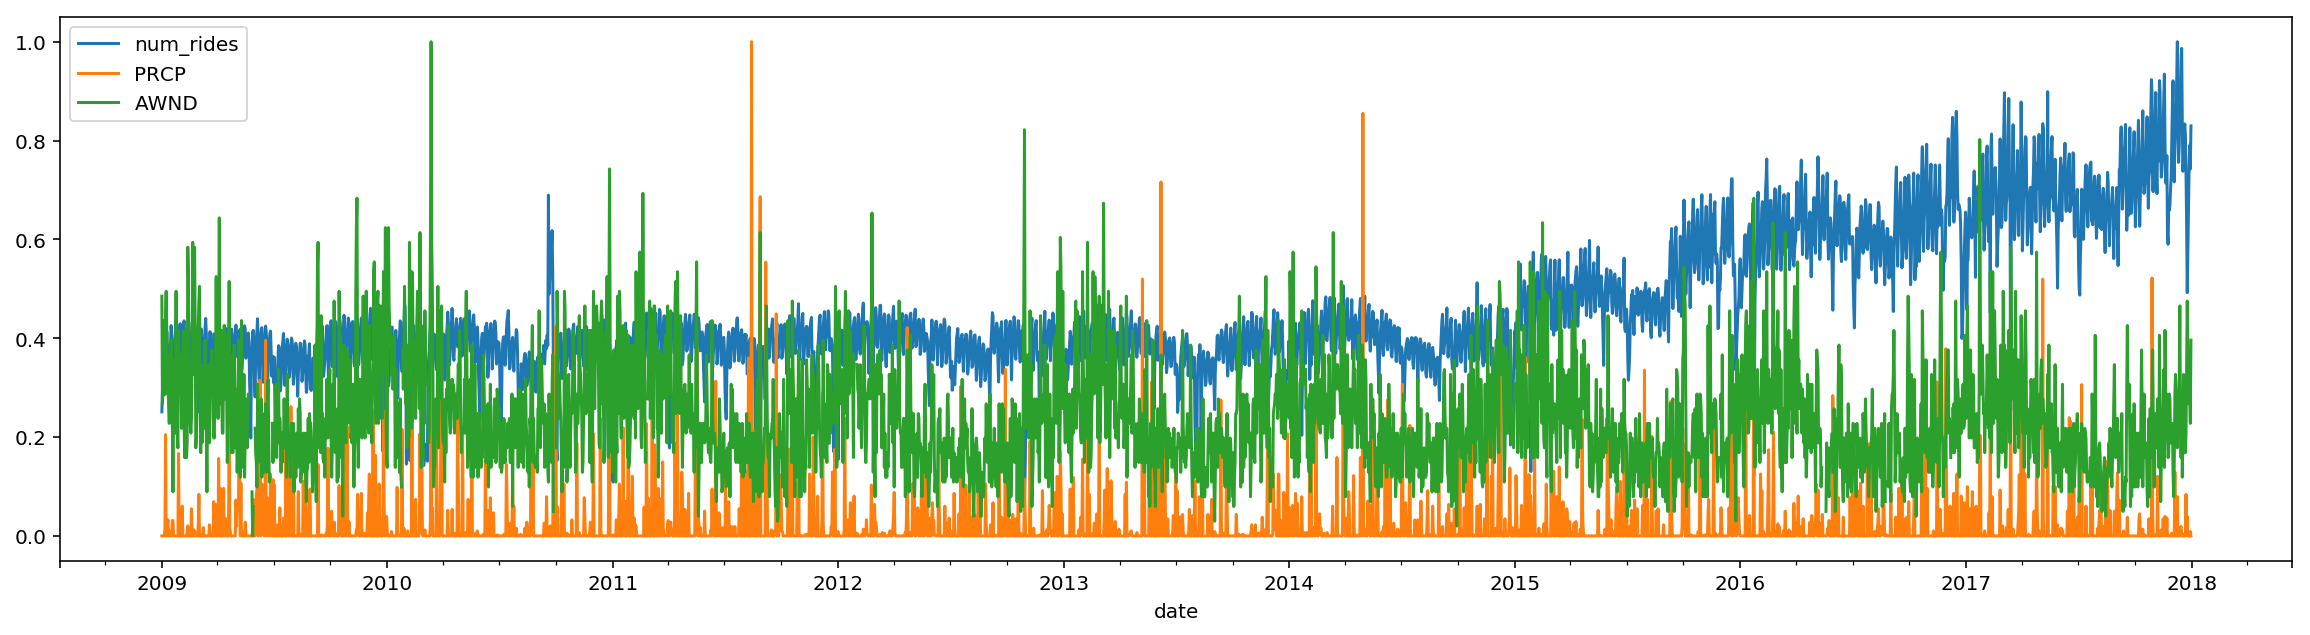

In [18]:
data_minmax[['num_rides', 'PRCP', 'AWND']].plot(figsize=(20, 5))

* The level of number of rides is increasing over time (trend) whereas the levels of precipitation and average wind speed are relatively constant.
* Average wind speed shows a yearly pattern with much more wind during the winter.
* Precipitation is relatively spiky.

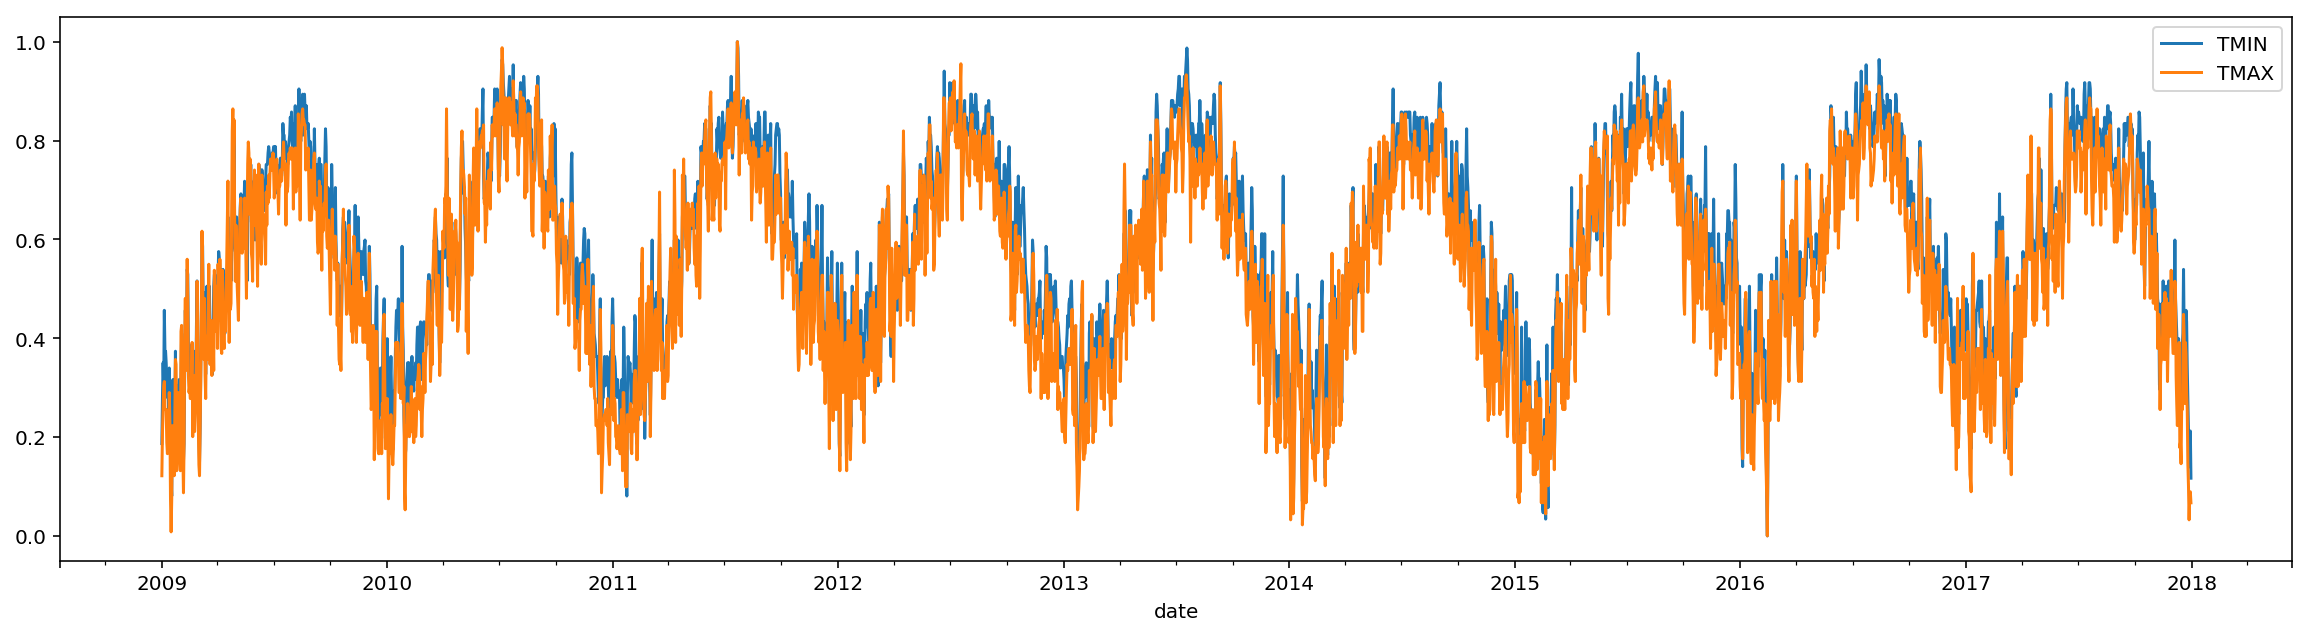

In [19]:
data_minmax[['TMIN', 'TMAX']].plot(figsize=(20, 5))

* Temperature level is fairly stationary and shows the expected pattern during a year.

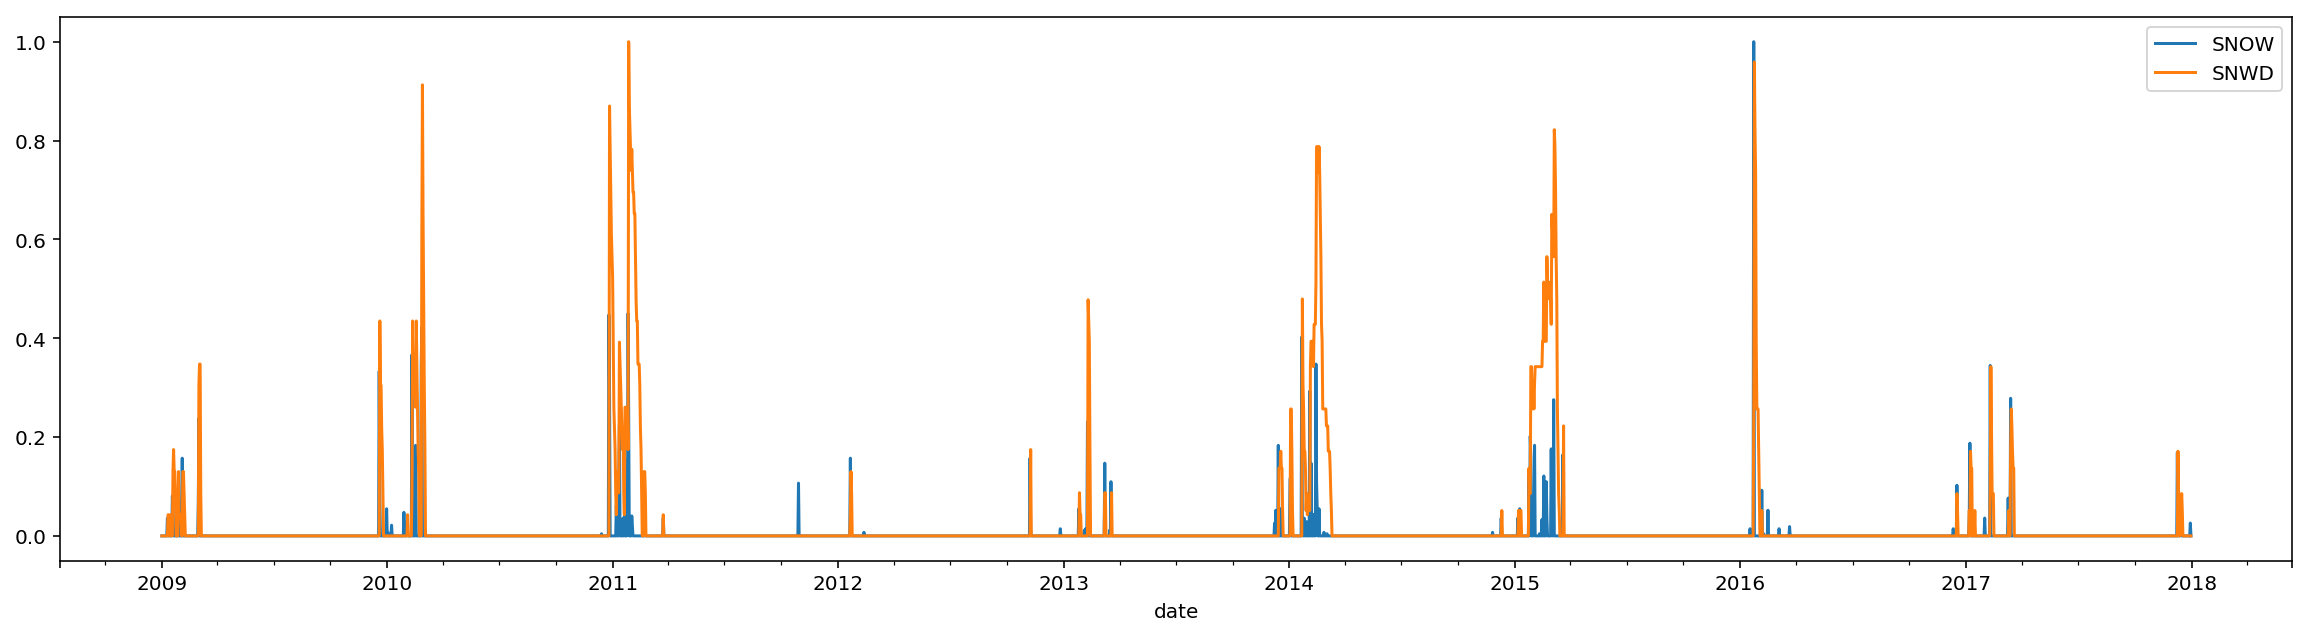

In [20]:
data_minmax[['SNOW', 'SNWD']].plot(figsize=(20, 5))

* Snow does not show any seasonal pattern except that it normally happens during the winter months (as expected).

## Standard Scaling to Understand How Extreme Single Points Are

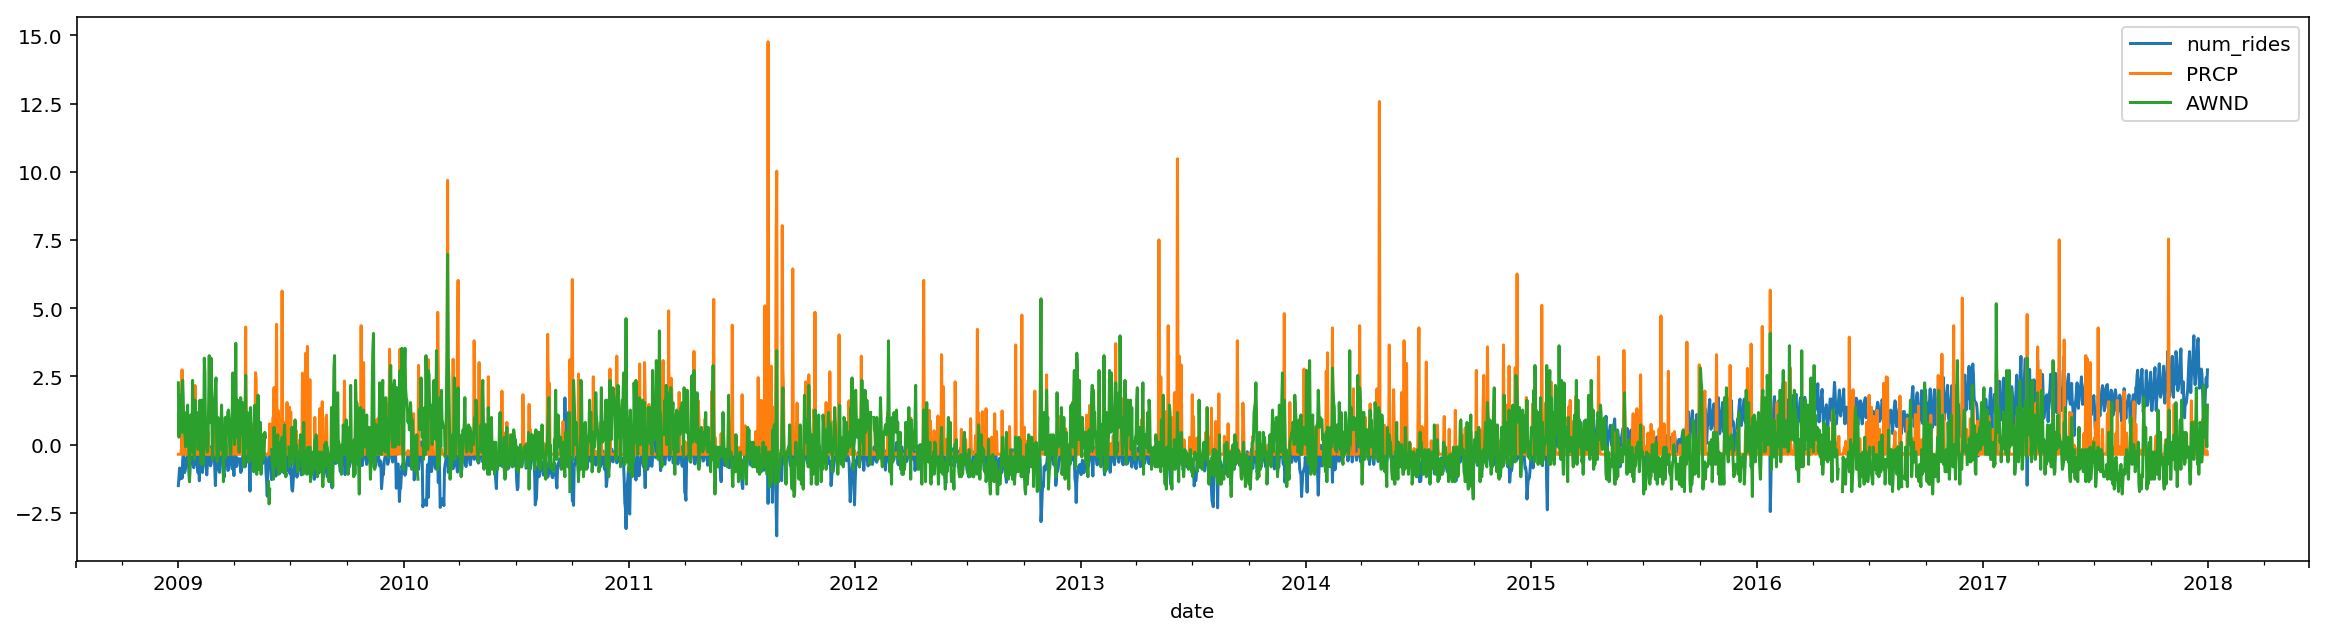

In [21]:
data_std[['num_rides', 'PRCP', 'AWND']].plot(figsize=(20, 5))

* Precipitation shows quite a few peaks that are 5-15x the standard deviation from the mean. These will be investigated separately to see if number of rides show extreme values on these day as well.

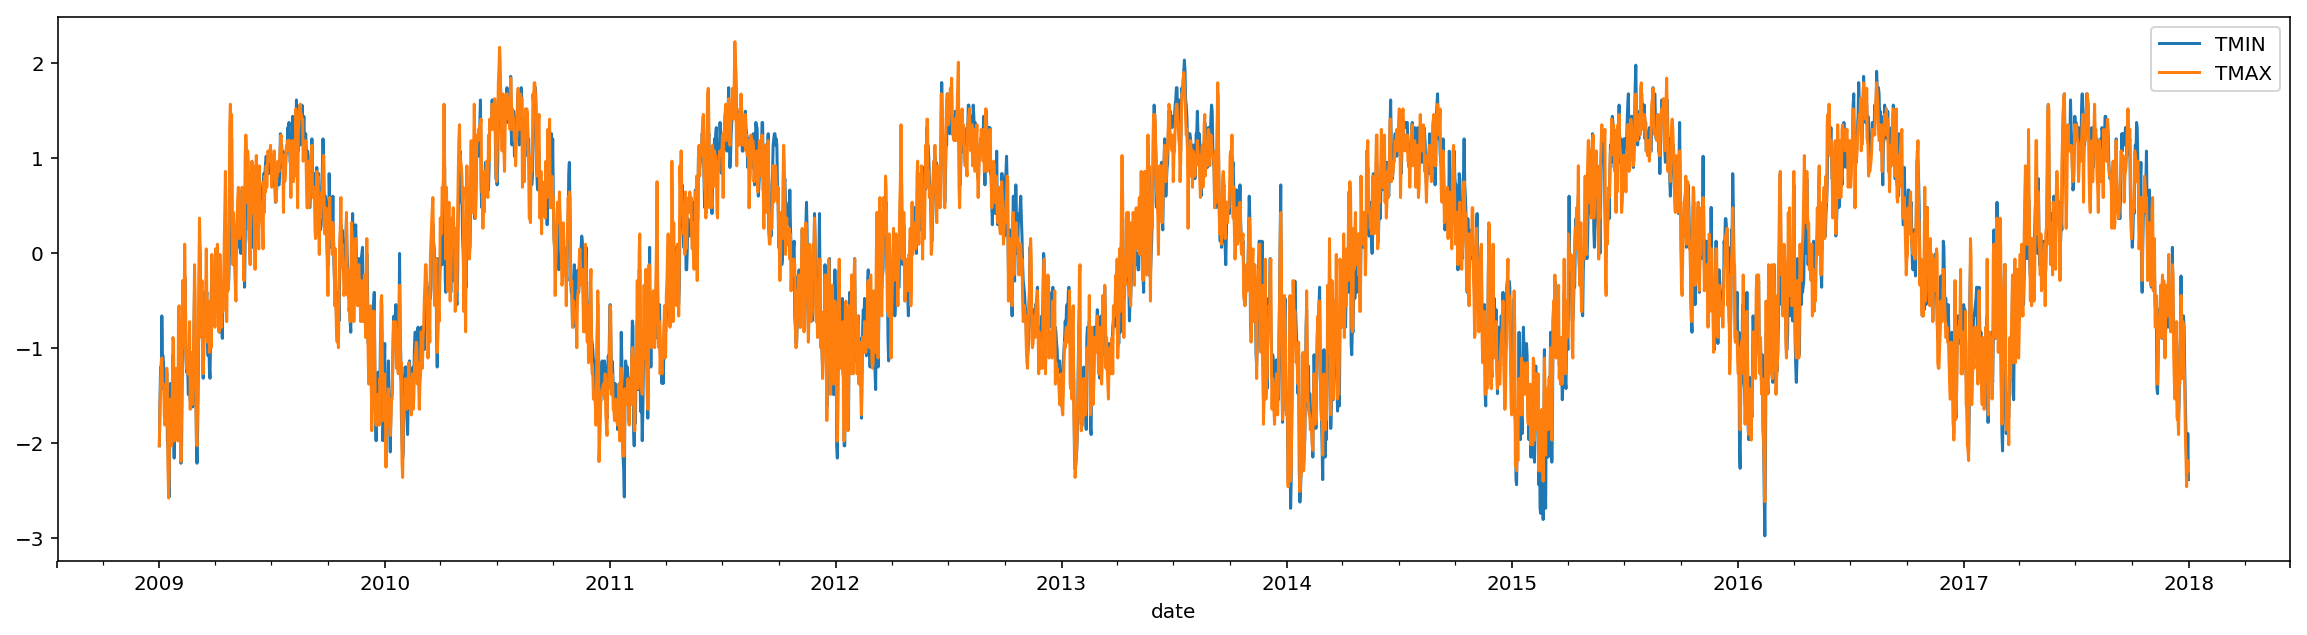

In [22]:
data_std[['TMIN', 'TMAX']].plot(figsize=(20, 5))

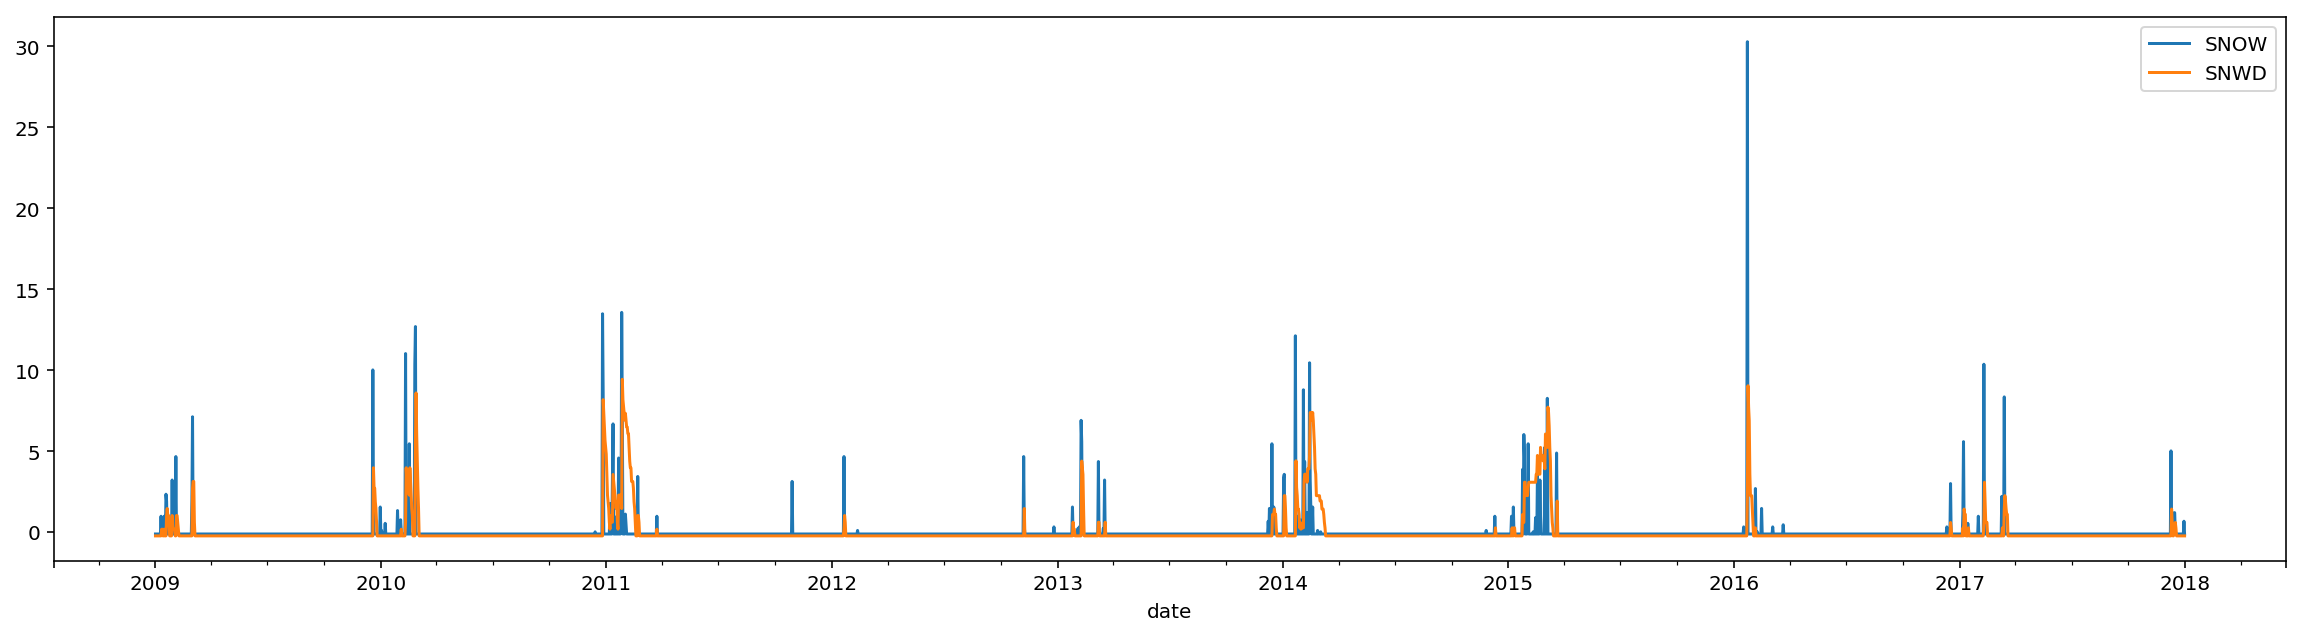

In [23]:
data_std[['SNOW', 'SNWD']].plot(figsize=(20, 5))

# Plot Sorted Number of Rides Against Other Variables

* Approach: Plot sorted number of rides (standardised) against other variables to identify whether there's a direct correlation between the levels.

In [24]:
sorted_by_rides = (data.sort_values(by='num_rides', ascending=True)
                   .join(data_std, lsuffix='_default', rsuffix='_std'))

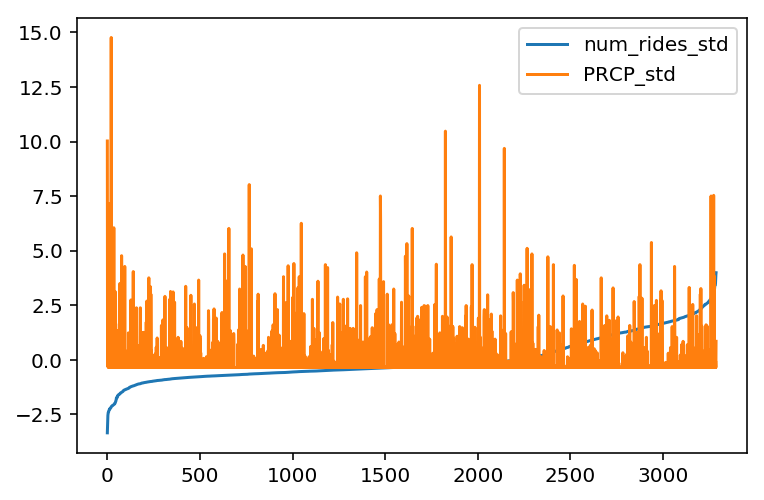

In [25]:
sorted_by_rides.reset_index()[['num_rides_std', 'PRCP_std']].plot()

* For precipitation, there's no clear pattern. However, the hardest rainfalls caused very little taxi rides (28 Aug 2011).

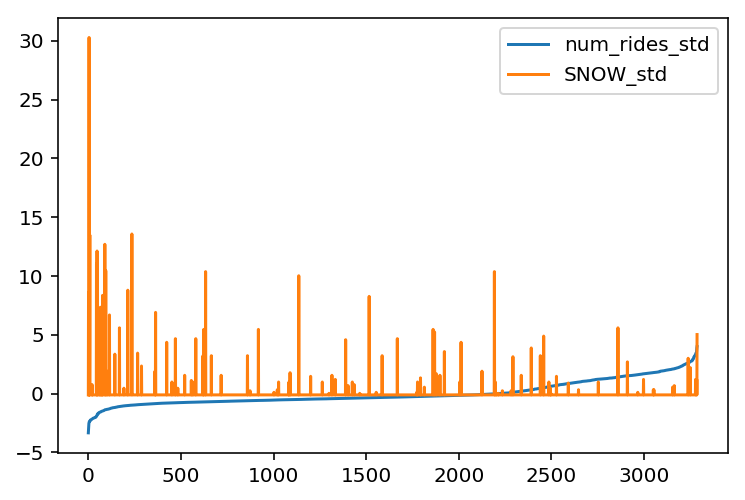

In [26]:
sorted_by_rides.reset_index()[['num_rides_std', 'SNOW_std']].plot()

* Snow, however, shows a different pattern. The more significantly less the number of rides per day is than the mean, the more snow there was on that day. There are exceptions to this as well, but the general pattern can be seen.

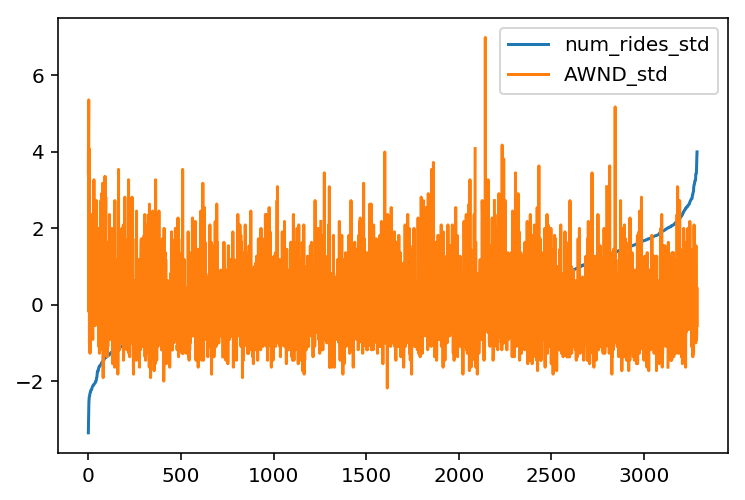

In [27]:
sorted_by_rides.reset_index()[['num_rides_std', 'AWND_std']].plot()

* The wind does not show any pattern with the number of rides (on a global scale).

# Timely Patterns

* Now, let's better understand the timely patterns within certain periods.

## Full Period with Resampled Values

### Yearly

In [28]:
yearly = data_std.resample('Y').mean()

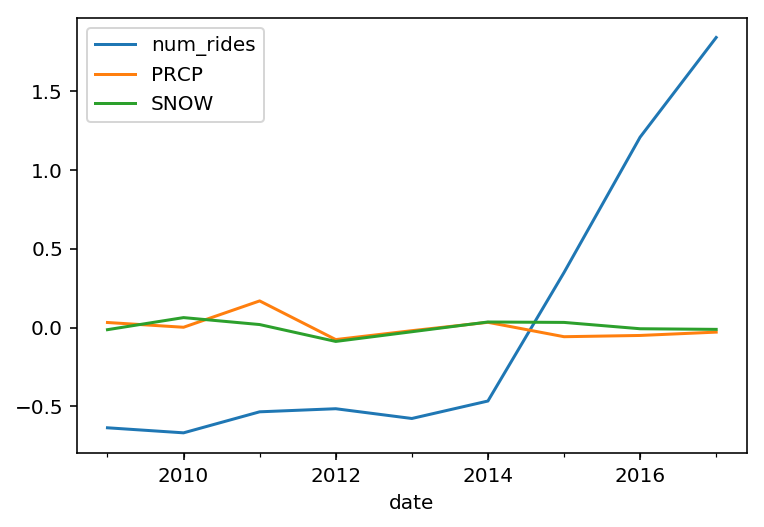

In [29]:
yearly[['num_rides', 'PRCP', 'SNOW']].plot()

* Observation: Nothing to see here except the already seen trend of number of rides.

### Quarterly

In [30]:
quarterly = data_std.resample('Q').mean()

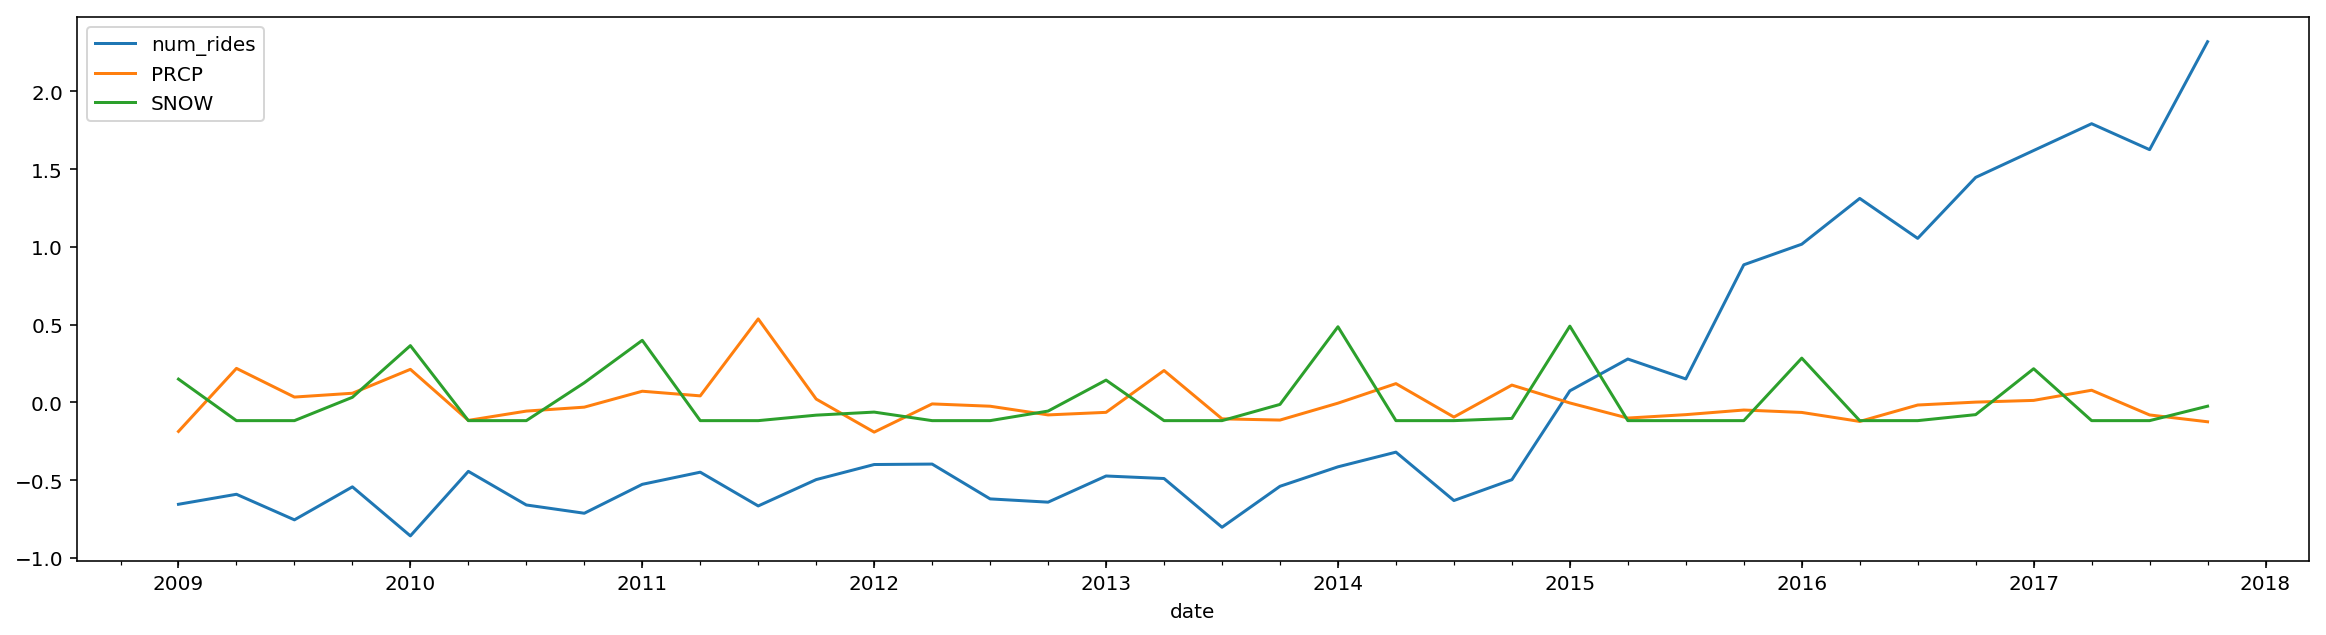

In [31]:
quarterly[['num_rides', 'PRCP', 'SNOW']].plot(figsize=(20,5))

* Observation: Seems that some of the spikes could co-occur. Let's go a bit deeper.

### Monthly

In [32]:
monthly = data_std.resample('M').mean()

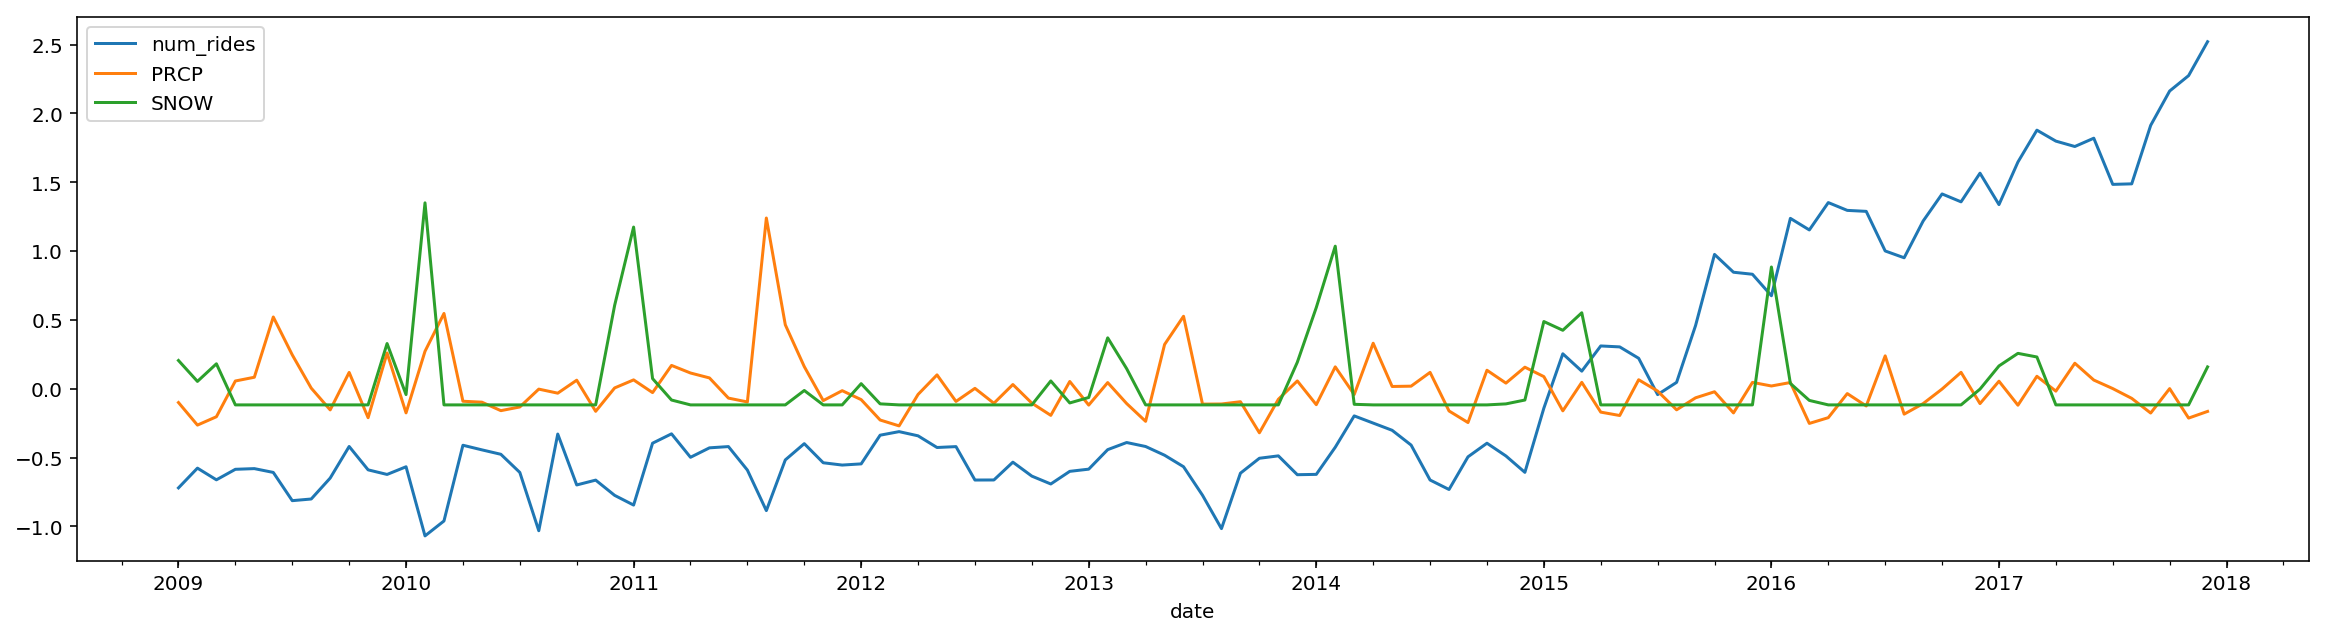

In [33]:
monthly[['num_rides', 'PRCP', 'SNOW']].plot(figsize=(20,5))

* Observation: Now, a lot clearer. Seems if snow or rain are significantly higher than average, the number of rides drops.

### Weekly

In [34]:
weekly = data_std.resample('W').mean()

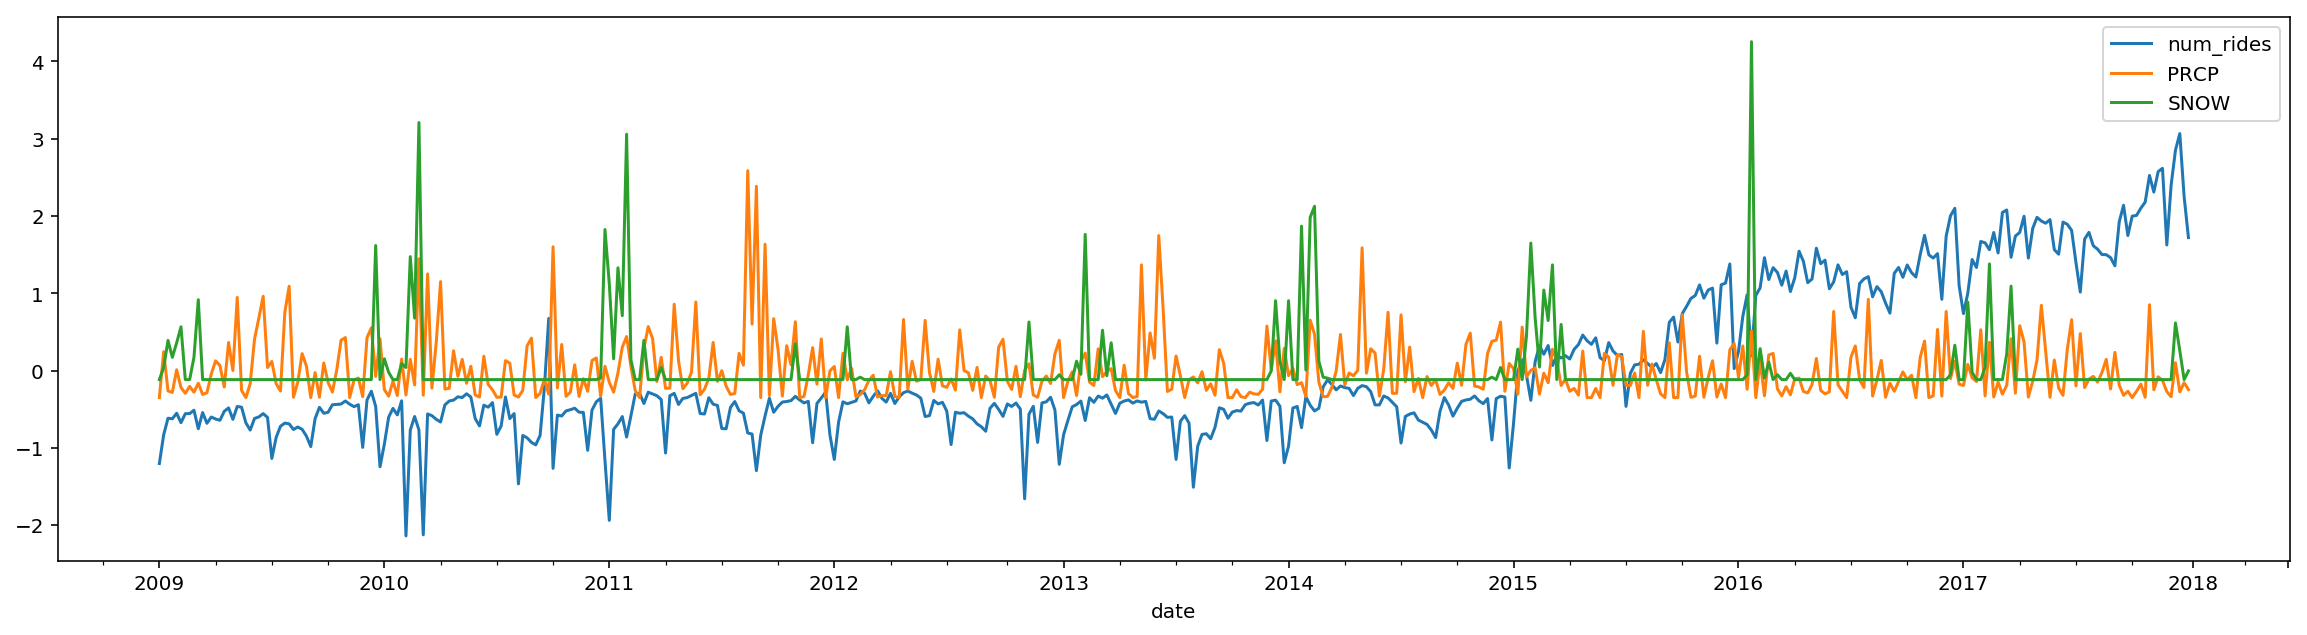

In [35]:
weekly[['num_rides', 'PRCP', 'SNOW']].plot(figsize=(20,5))

* Observation: Pattern can be confirmed here.

## Specific Periods (Averaged)

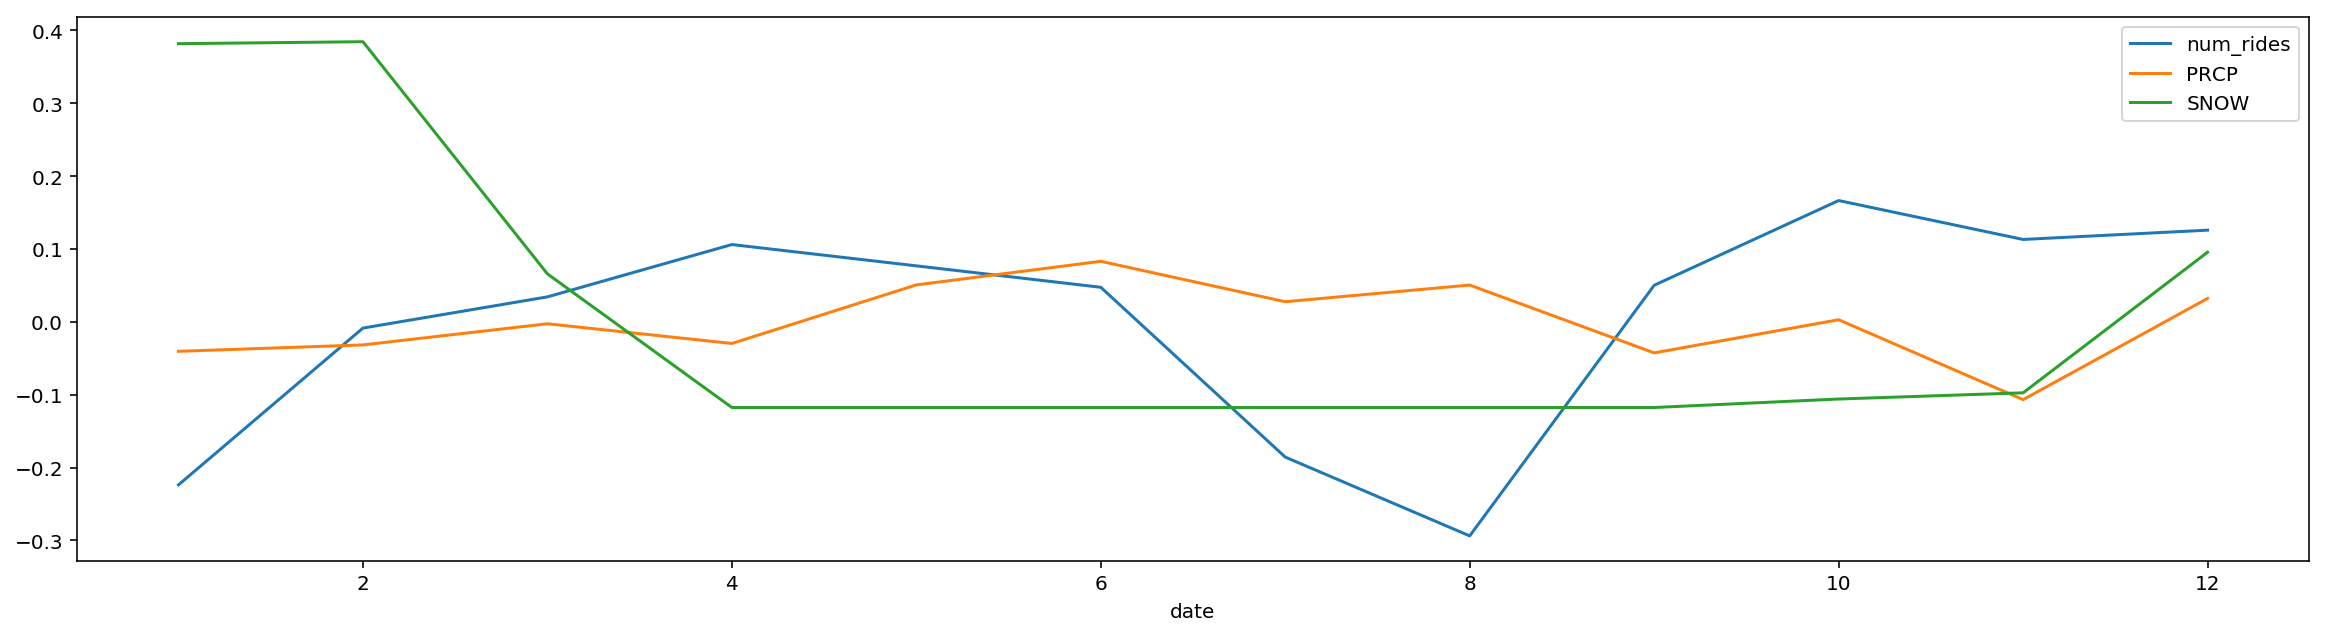

In [36]:
data_std.groupby(data_std.index.month).mean()[['num_rides', 'PRCP', 'SNOW']].plot(figsize=(20,5))

* Observation: There are significantly less rides during the summer months (July, August) and January.

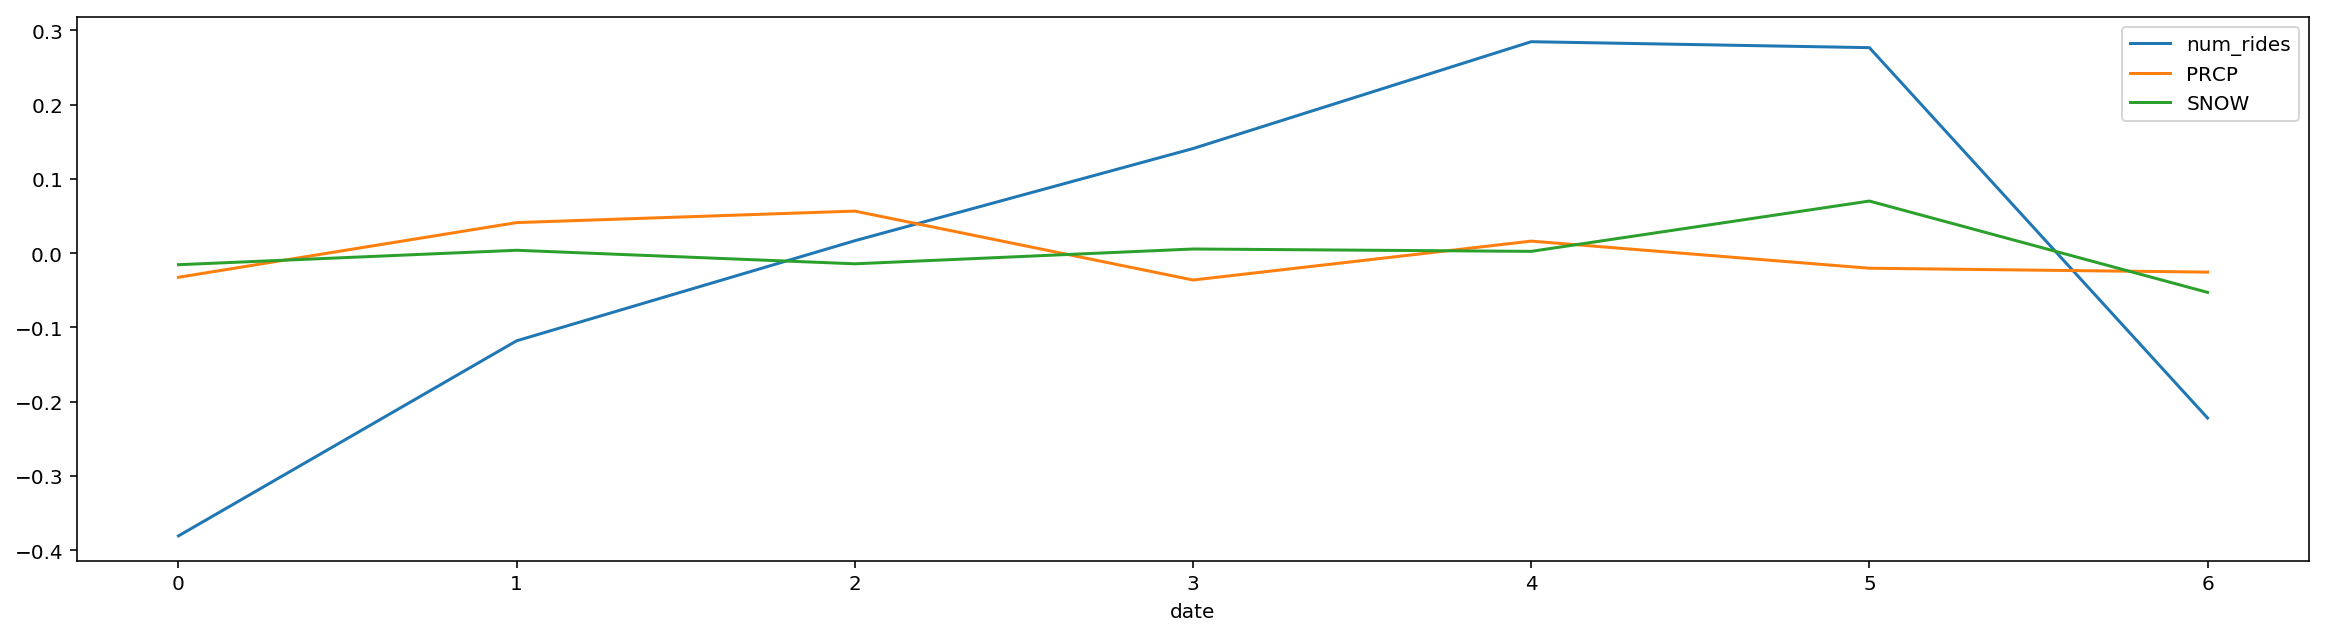

In [37]:
data_std.groupby(data_std.index.weekday).mean()[['num_rides', 'PRCP', 'SNOW']].plot(figsize=(20,5))

* Observation: On average, there are less rides on Mondays, Tuesdays and Sunday, and most rides on Friday/Saturday.

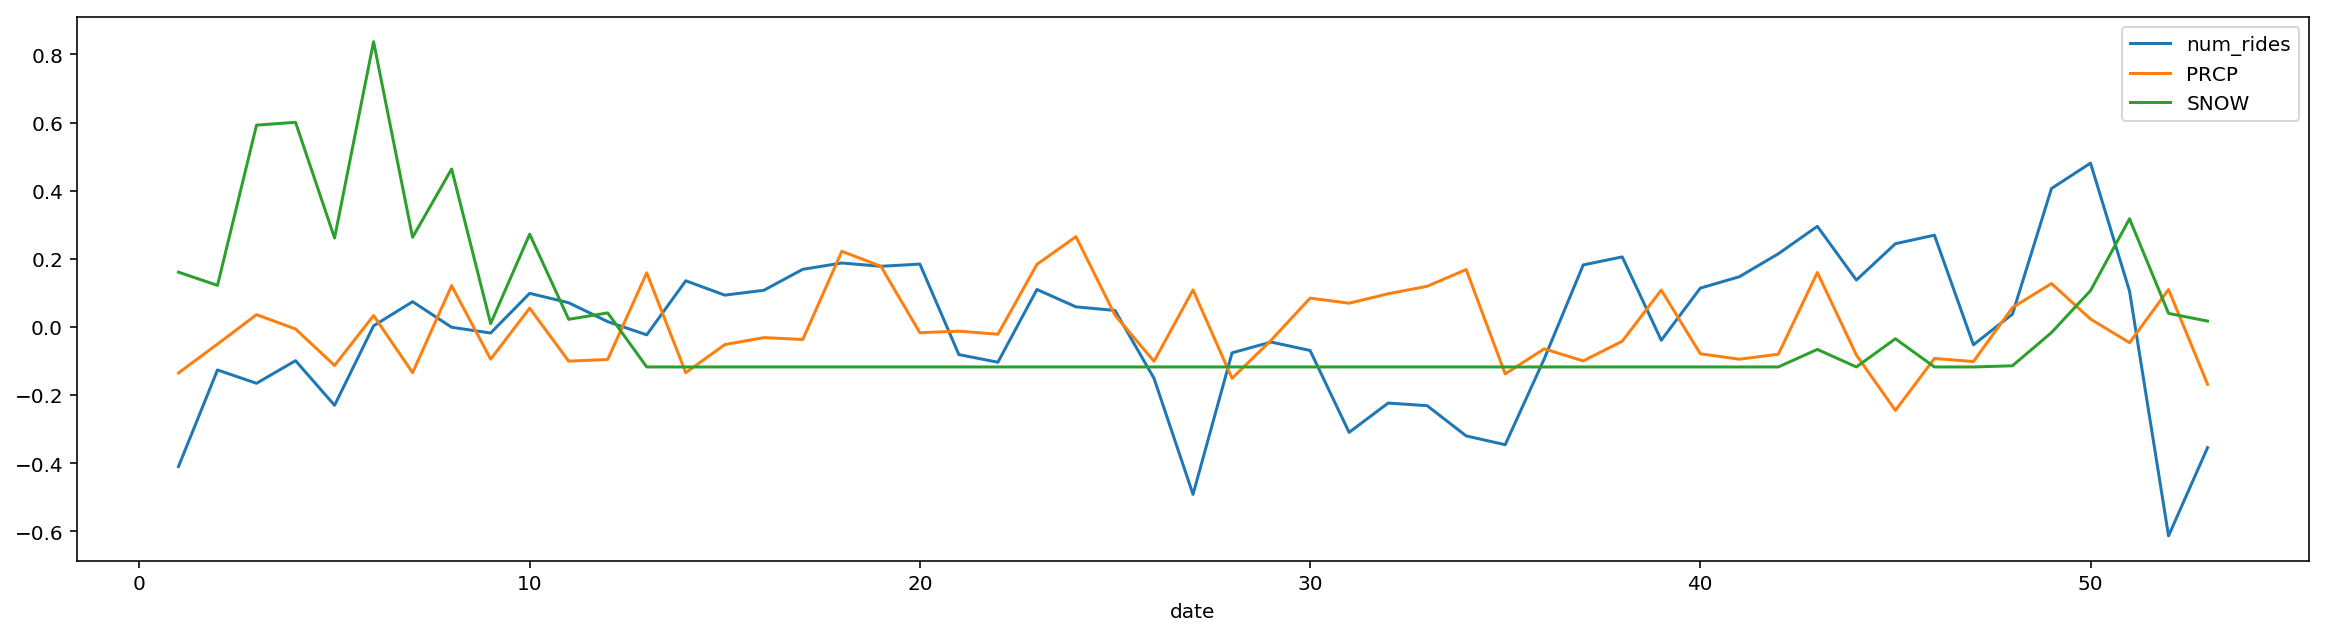

In [38]:
data_std.groupby(data_std.index.weekofyear).mean()[['num_rides', 'PRCP', 'SNOW']].plot(figsize=(20,5))

Observations:
* This graph shows patterns over the year (averaged by week). The previously observed pattern that more precipitation or snow results in less rides can be seen here as well.

# Exemplary Exploration of Spikes to Understand Patterns

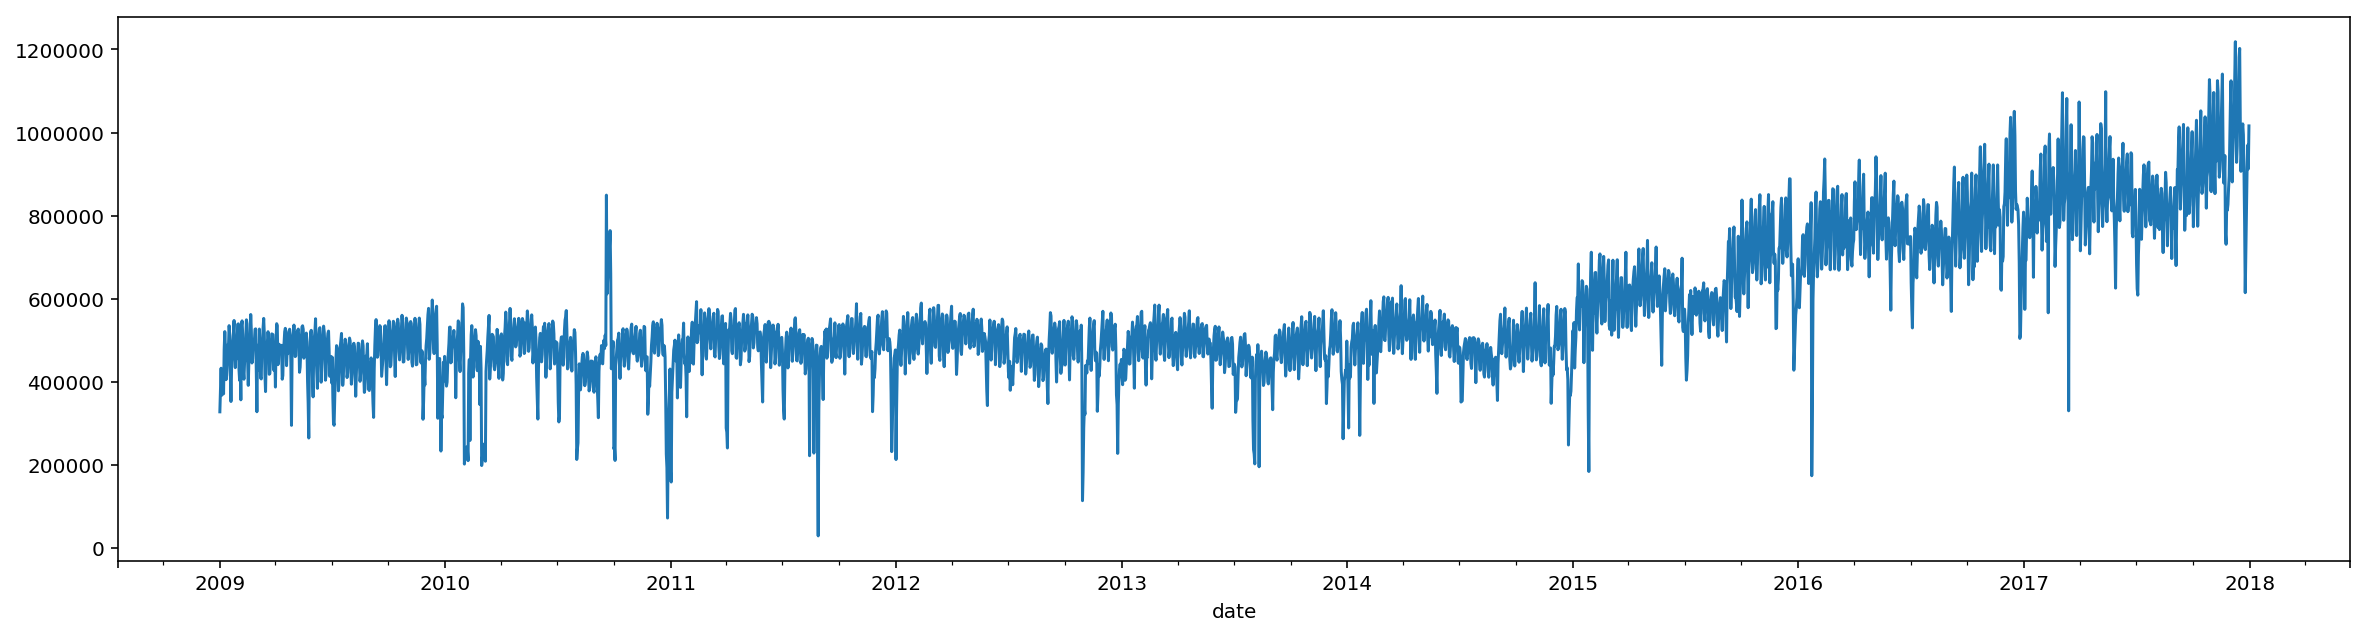

In [48]:
data['num_rides'].plot(figsize=(20,5))

* Clearly, the big drops occur much more frequently around December/January. Together with the previous observations, this indicates that snow is a driver for traffic drops.

## Peak in September 2010 (>800k Rides on 19 Sept)

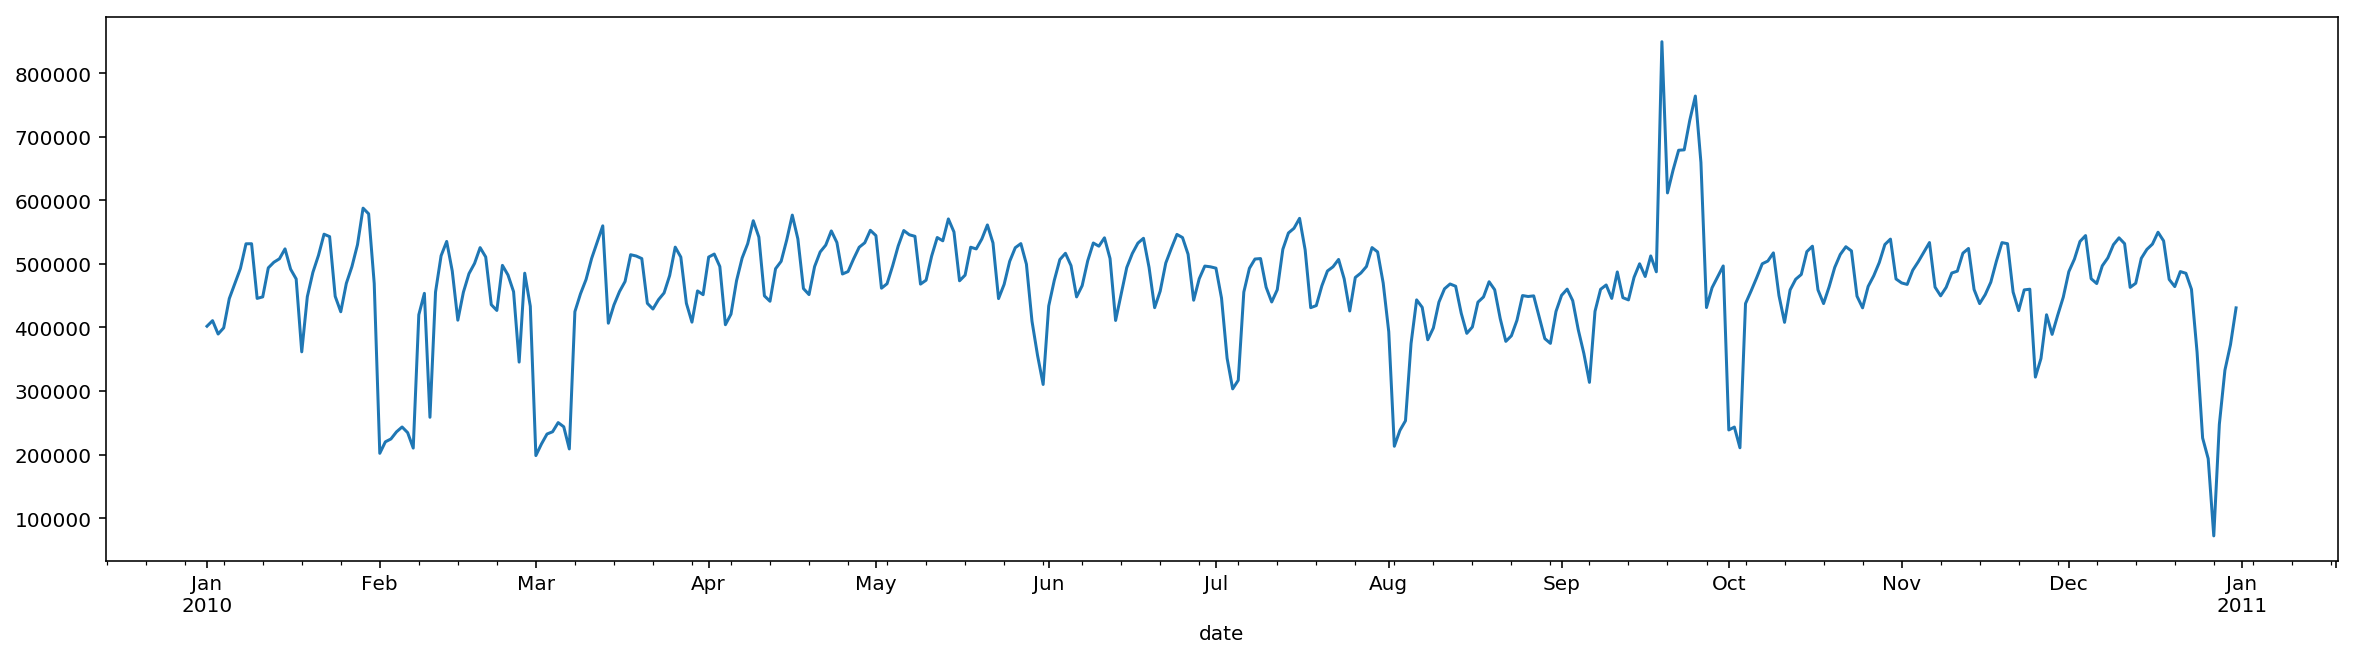

In [47]:
data[data.index.year == 2010]['num_rides'].plot(figsize=(20,5))

In [49]:
data[(data.index.year == 2010) & (data.index.month == 9)]

,num_rides,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
date,,,,,,,
2010-09-01,450430,1.4,0.0,0.0,0.0,35.6,24.4
2010-09-02,460210,2.7,0.0,0.0,0.0,34.4,25.6
2010-09-03,442044,2.7,0.0,0.0,0.0,29.4,23.9
2010-09-04,396123,4.7,0.0,0.0,0.0,27.2,17.8
2010-09-05,358956,2.3,0.0,0.0,0.0,25.6,16.1
2010-09-06,313522,1.9,0.0,0.0,0.0,26.7,15.6
2010-09-07,425314,2.8,0.0,0.0,0.0,31.7,20.0
2010-09-08,459918,3.7,0.0,0.0,0.0,32.2,18.9
2010-09-09,466722,3.1,0.0,0.0,0.0,21.1,16.1


* There is no specific weather pattern around 19 Sept, 2010, so this was probably to due to some event.

## Drop in December 2010

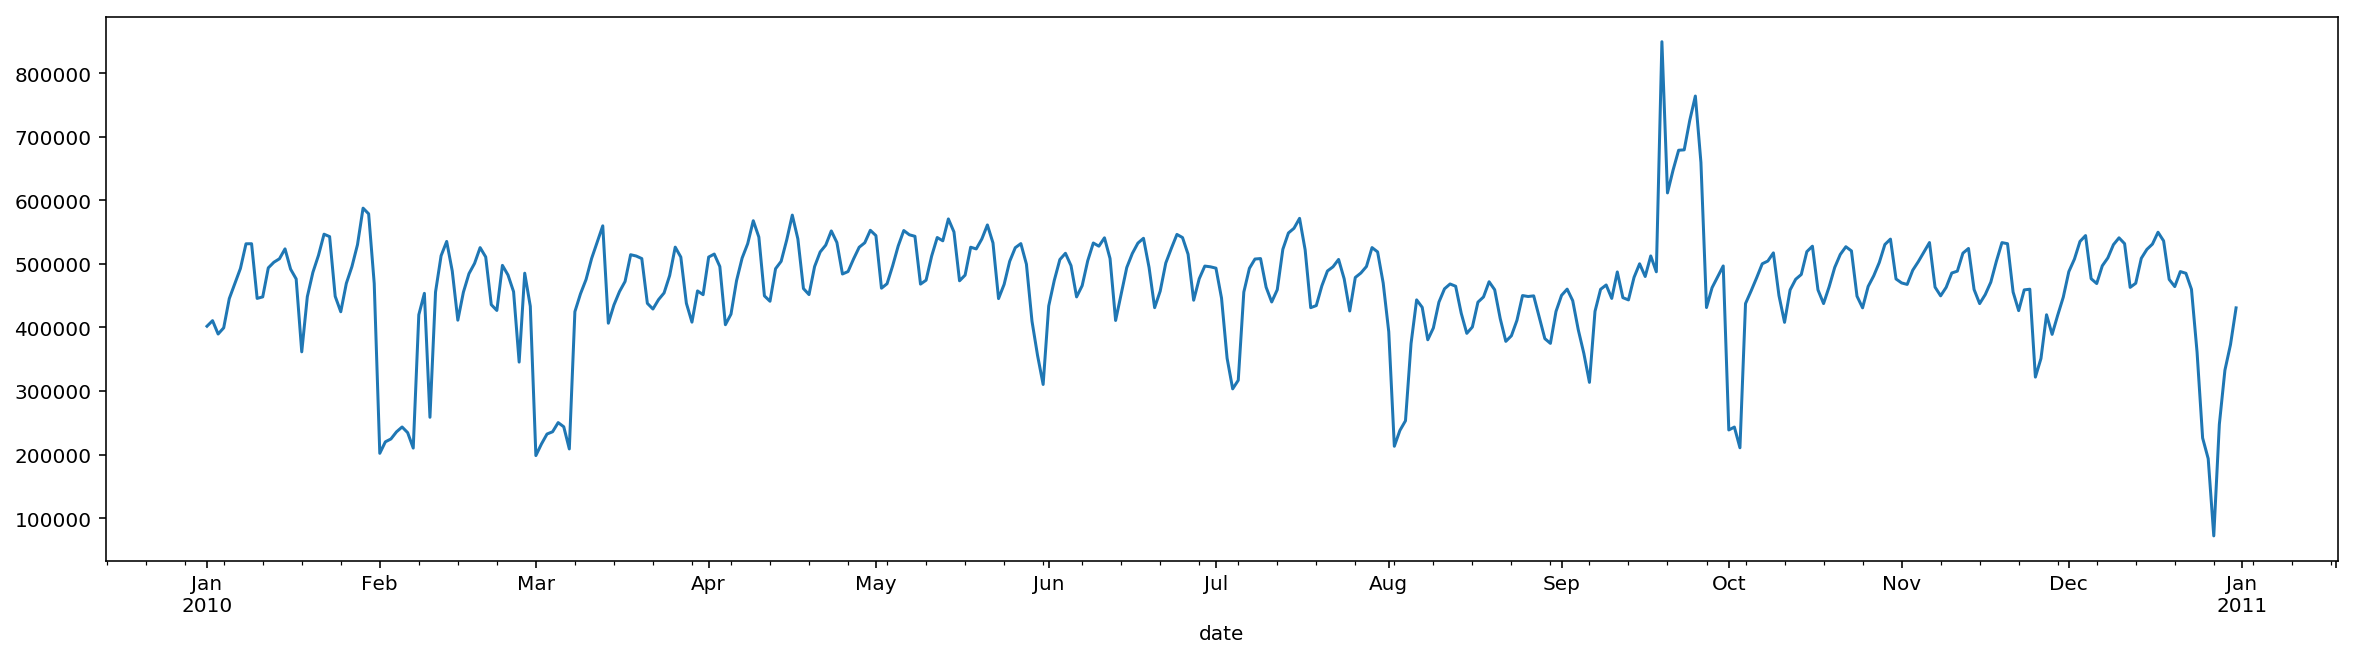

In [50]:
data[data.index.year == 2010]['num_rides'].plot(figsize=(20,5))

In [51]:
data[(data.index.year == 2010) & (data.index.month == 12)]

,num_rides,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
date,,,,,,,
2010-12-01,487760,5.1,30.5,0.0,0.0,15.6,4.4
2010-12-02,507371,3.3,0.0,0.0,0.0,5.6,1.1
2010-12-03,535199,2.7,0.0,0.0,0.0,4.4,0.6
2010-12-04,544471,3.7,0.0,0.0,0.0,4.4,0.0
2010-12-05,476614,4.4,0.0,0.0,0.0,1.7,-1.1
2010-12-06,468980,4.8,0.0,0.0,0.0,1.7,-1.1
2010-12-07,496863,4.5,0.0,0.0,0.0,2.2,-1.1
2010-12-08,509366,4.3,0.0,0.0,0.0,1.1,-2.8
2010-12-09,530098,3.6,0.0,0.0,0.0,-1.1,-5.0


* Clearly, NYC received lots of snow on 26 Dec 2010, and taxi rides dropped significantly on that day. Due to the snow melting slowly, taxi rides stays lower than usual for the next couple of days as well.

## Drop in August 2011

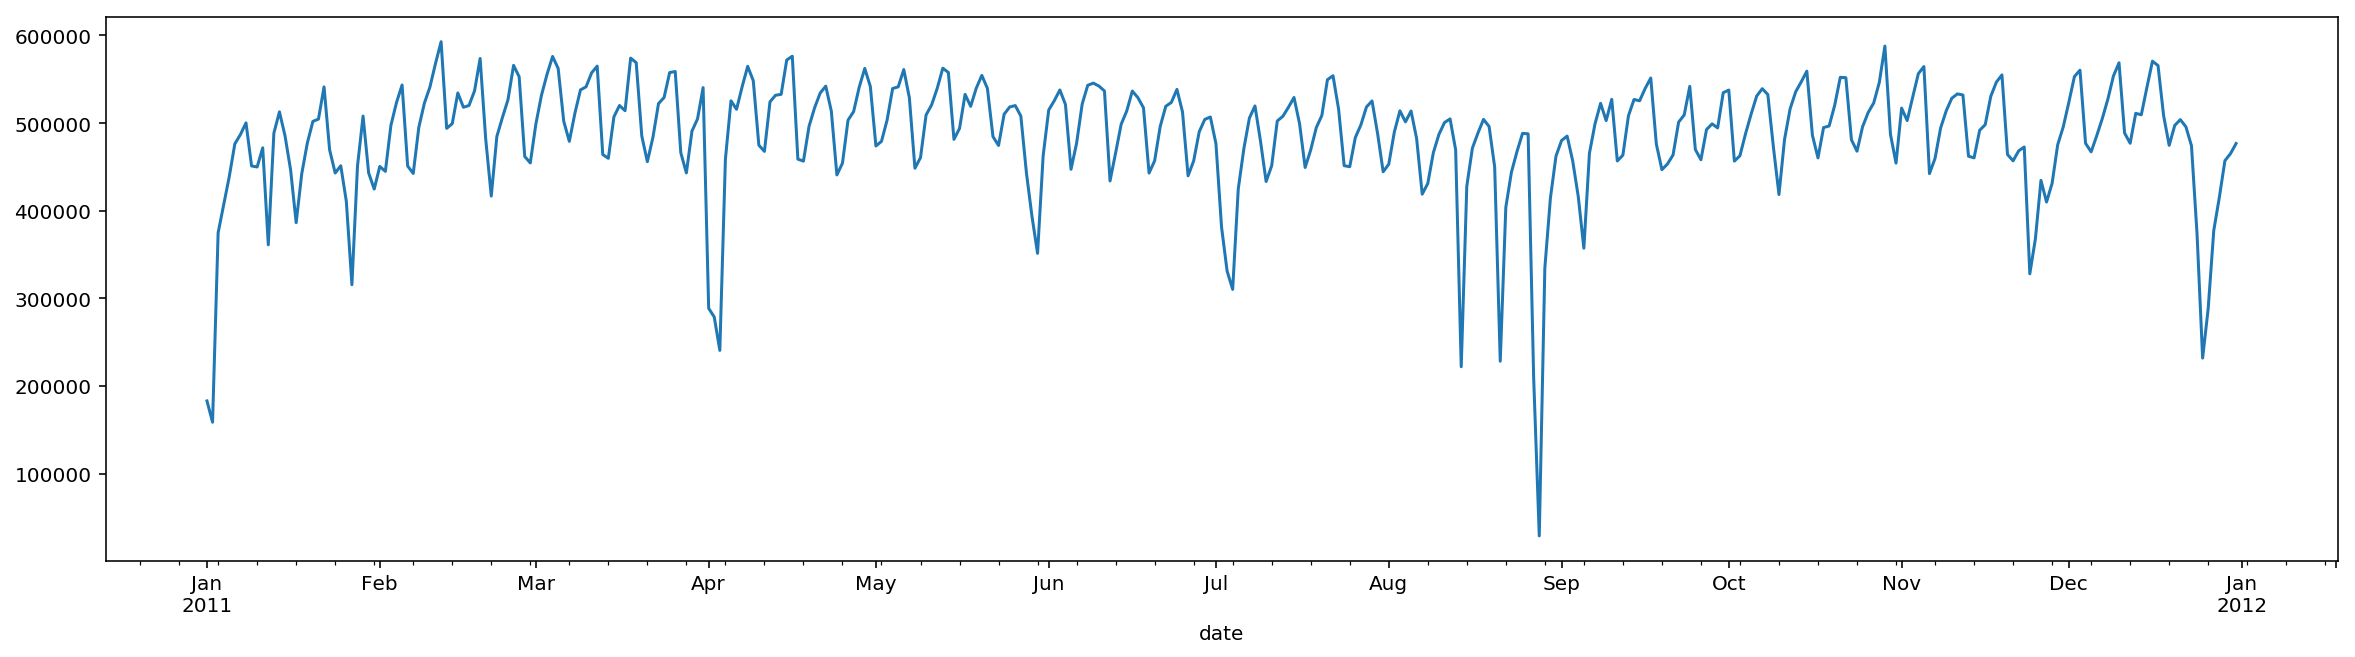

In [52]:
data[data.index.year == 2011]['num_rides'].plot(figsize=(20,5))

In [53]:
data[(data.index.year == 2011) & (data.index.month == 8)]

,num_rides,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
date,,,,,,,
2011-08-01,453134,1.4,0.5,0.0,0.0,34.4,21.7
2011-08-02,489837,1.7,0.0,0.0,0.0,32.8,22.8
2011-08-03,514042,1.4,19.3,0.0,0.0,31.1,19.4
2011-08-04,501436,2.1,0.0,0.0,0.0,28.9,19.4
2011-08-05,513817,2.0,0.0,0.0,0.0,30.0,21.1
2011-08-06,482363,2.6,4.8,0.0,0.0,29.4,22.2
2011-08-07,418949,1.6,4.1,0.0,0.0,31.7,22.8
2011-08-08,431148,1.9,0.0,0.0,0.0,32.2,23.3
2011-08-09,466284,2.0,53.1,0.0,0.0,28.3,21.7


* Observation: On days with lots of rain (e.g. 28 Aug, 2011), there are significantly less taxi rides. Additionally, on 28 Aug, 2011, it was stormy, resulting in an all-time low in rides.

# Weather Variable

In [54]:
data_std.head()

,num_rides,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
date,,,,,,,
2009-01-01,-1.502526,2.266128,-0.350518,-0.117487,-0.234364,-2.031363,-2.032681
2009-01-02,-1.200469,0.272622,-0.350518,-0.117487,-0.234364,-1.598931,-1.558399
2009-01-03,-0.855192,1.813059,-0.350518,-0.117487,-0.234364,-1.382716,-1.202687
2009-01-04,-1.257086,0.816305,-0.350518,-0.117487,-0.234364,-1.156672,-1.439828
2009-01-05,-1.236271,0.544464,-0.350518,-0.117487,-0.234364,-1.107532,-0.663729


In [73]:
w = pd.DataFrame(data=data['num_rides'], columns=['num_rides'])

In [74]:
w['weather_variable'] = data_std['AWND'] + data_std['PRCP'] + data_std['SNOW'] + data_std['SNWD']

In [75]:
w.head()

,num_rides,weather_variable
date,,
2009-01-01,327716,1.563760
2009-01-02,376708,-0.429747
2009-01-03,432710,1.110690
2009-01-04,367525,0.113937
2009-01-05,370901,-0.157905


In [76]:
w.corr()

,num_rides,weather_variable
num_rides,1.000000,-0.121443
weather_variable,-0.121443,1.000000
